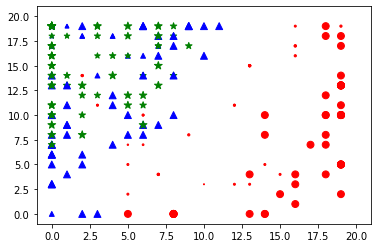

In [2]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import csv
import pandas as pd
df = pd.read_csv('iris_data.csv')
N = 20#linear size of 2D map
n_teacher = len(df) #教師データの数(学習回数)#行数
np.random.seed(1000)#シード (種) を指定することで、発生する乱数をあらかじめ固定
dimension = 4#ベクトルの次元
i = 0
def main():
    #初期ノード
    # N x N ×dimension の配列の乱数
    nodes = np.random.rand(N, N, dimension)#0.0~1.0の値で一様分布

    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                M = df.iloc[:,z].max()
                m = df.iloc[:,z].min()
                nodes[x, y, z] = 0.5 *(M - m) * nodes[x, y, z] + m
    
    #BMUとクラスを記録するためのcsvファイルを開く
    with open('bmu.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['index','bmu','classnum'])
        
    ax = plt.subplot()
    for df3 in range(2):
        df3 = pd.read_csv('iris_data.csv')
        
        for i in range(n_teacher):#150回
            #教師信号
            teachers = np.array(df.loc[i,'SepalLength':'PetalWidth'].values) #X #150 * 4
            train(nodes, teachers)
            bmu = best_matching_unit(nodes, teachers)
            y = np.array(df.loc[:, ['Name']].values)

            #csvファイルにBMUとそのクラスを追記
            with open('bmu.csv', 'a') as f: 
                writer = csv.writer(f)
                writer.writerow([i,bmu,y[i]])
            
            df2 = pd.read_csv('bmu.csv')
            if y[i] != df2['classnum'].any:
                if y[i]==[0]:#setosa
                    col='red'
                    mark = 'o'

                elif y[i]==[1]:#versicolor
                    col='blue'
                    mark = '^'

                elif y[i]==[2]:#Virginia
                    col='green'
                    mark = '*'

            
            #elif y[i] == df2['classnum']:#df2.iloc[:,'classnum'] == y[i]:
                #col = 'black'
                #mark = 'x'
            
            scale = 1 * df2['bmu'].value_counts()#unique()#value_counts()
            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale, alpha = 1.0)
            #plt.savefig(f'som{i}.png', dpi = 400, bbox_inches = 'tight')
    for i in range(n_teacher):
        
        if y[i] == df2['classnum'].any:#df2.iloc[:,'classnum'] == y[i]:
            col = 'black'
            mark = 'x'
            scale = 10
            ax.scatter(bmu[0],bmu[1],color = col, marker=mark, s=scale)
            
    plt.xlim(0-1,N+1)
    plt.ylim(0-1,N+1)
    plt.show()
    
#学習   
def train(nodes, teachers):
    
    bmu = best_matching_unit(nodes, teachers)#BMU:データに対し最も似ているベクトルを持つユニットあとで定義

    for x in range(N):
        for y in range(N):
            c = np.array([x,y])
            d = np.linalg.norm(c - bmu)#ユニットの位置とBMUとの距離
            L = learning_ratio(i)#学習時間を決定するパラメータ#iはe^(-t/λ)
            S = learning_radius(i, d)#更新するユニットがどの程度BMUの近傍にいるのかを表現
            for z in range(dimension):
                nodes[x, y, z] += L * S * (teachers[z] - nodes[x, y, z])#zはがくの長さなど

                
def best_matching_unit(nodes, teacher):
    norms = np.zeros((N,N))# N×Nの２次元配列を生成
    for x in range (N):
        for y in range(N):
            for z in range(dimension):
                norms[x, y] += (nodes[x,y,z] - teacher[z])**2
    
    bmu_1 = np.argmin(norms)#１次元配列で考えたとき何番目かを返す
    bmu = np.unravel_index(bmu_1,(N,N))#argminと組み合わせることで,もとの行列の何行何列目に最小値があるのかわかる

    return bmu 

def neighbourhood(t):
    halflife = float(n_teacher/4)#時定数
    initial = float(N/4)
    return initial*np.exp(-t/halflife)

def learning_ratio(t):
    halflife=float(n_teacher/4)#時定数
    initial=0.1#Lの初期値
    return initial*np.exp(-t/halflife)

def learning_radius(t, d):
    s=neighbourhood(t)
    return np.exp(-d**2/(2*s**2))

main()